#Master equation model of the alanine dipeptide

First we import a number of libraries we will need as we run this example

In [123]:
%autoreload 2
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from mastermsm.trajectory import traj
import mdtraj as md
from mastermsm.trajectory import traj_lib

Then we can start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of methods for parsing and calculating interestign properties of our time-series data.

In [124]:
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])

In [125]:
print tr.mdt

<mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells>


In [126]:
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

In [127]:
print phi
print psi
print res

(array([[ 4,  6,  8, 14]]), array([[-2.3704083 ],
       [-2.31717944],
       [-2.65259457],
       ..., 
       [-1.00608552],
       [-1.1628679 ],
       [-1.34959686]], dtype=float32))
(array([[ 6,  8, 14, 16]]), array([[ 2.02370429],
       [ 2.4803381 ],
       [ 3.07054257],
       ..., 
       [-0.77070665],
       [-0.55082983],
       [-1.14936423]], dtype=float32))
[ACE1, ALA2, NHE3]


In [128]:
tr.discretize()

(array([[ 4,  6,  8, 14]]), array([[-2.3704083 ],
       [-2.31717944],
       [-2.65259457],
       ..., 
       [-1.00608552],
       [-1.1628679 ],
       [-1.34959686]], dtype=float32)) (array([[ 6,  8, 14, 16]]), array([[ 2.02370429],
       [ 2.4803381 ],
       [ 3.07054257],
       ..., 
       [-0.77070665],
       [-0.55082983],
       [-1.14936423]], dtype=float32))


In [141]:
y = [0 if x == 'A' else 1 for x in tr.distrajs]


(-0.2, 1.2)

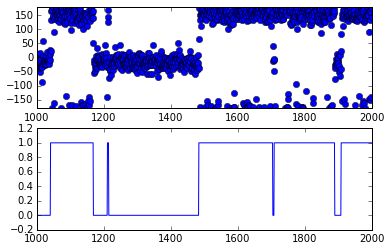

In [142]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(psi[1]*180/math.pi,'o')
ax2.plot(y)
ax1.set_xlim(1000,2000)
ax1.set_ylim(-180,180)
ax2.set_xlim(1000,2000)
ax2.set_ylim(-0.2,1.2)
